In [28]:
%matplotlib inline


In [29]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import numpy as np
import scipy
import scipy.ndimage as nd
import matplotlib
from matplotlib import pyplot as plt

import torch
from torchvision.datasets.mnist import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.distributions import Categorical
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from torch.nn.functional import one_hot, log_softmax, softmax, normalize


from collections import deque
import copy
import time
import random

from IPython.display import clear_output


# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [30]:
#Download mnist data
data_train = MNIST("./data/mnist",
                   download=True,
                   train=True,
                   transform=transforms.Compose([transforms.ToTensor()]))

data_val = MNIST("./data/mnist",
                 train=False,
                 download=True,
                 transform=transforms.Compose([transforms.ToTensor()]))

dataloader_train = DataLoader(
    data_train, batch_size=1000, shuffle=True, num_workers=8)
dataloader_val = DataLoader(data_val, batch_size=1000, num_workers=8)

dataloaders = {
    "train": dataloader_train,
    "val": dataloader_val,
}

digit_one, _ = data_val[5]

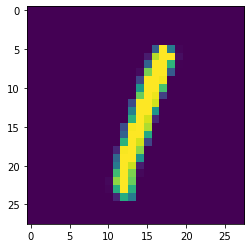

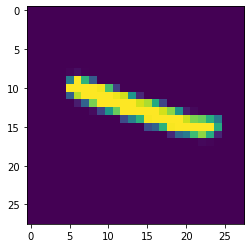

In [31]:
#Single digit test 
plt.imshow(digit_one.reshape(28,28))
plt.show()

def rotate_img(x, deg):
    rot_img = scipy.ndimage.rotate(x,deg,reshape=False)
    return rot_img

#Example rotation of digit one by 90 degrees
rot_one = rotate_img(digit_one.reshape(28,28),90)

tens_rot_one = rot_one
plt.imshow(tens_rot_one)
plt.show()

In [32]:
#Setup/utility functions
def get_device():
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda:0" if use_cuda else "cpu")
    return device

def one_hot_embedding(labels, num_classes=10):
    # Convert to One Hot Encoding
    y = torch.eye(num_classes)
    return y[labels]

#Check GPU available
device = get_device()
print(device)

cuda:0


In [33]:
#Loss Functions
def relu_evidence(y):
    return F.relu(y)

def kl_divergence(alpha, num_classes, device=None):
    if not device:
        device = get_device()
    ones = torch.ones([1, num_classes], dtype=torch.float32, device=device)
    sum_alpha = torch.sum(alpha, dim=1, keepdim=True)
    first_term = (
        torch.lgamma(sum_alpha)
        - torch.lgamma(alpha).sum(dim=1, keepdim=True)
        + torch.lgamma(ones).sum(dim=1, keepdim=True)
        - torch.lgamma(ones.sum(dim=1, keepdim=True))
    )
    second_term = (
        (alpha - ones)
        .mul(torch.digamma(alpha) - torch.digamma(sum_alpha))
        .sum(dim=1, keepdim=True)
    )
    kl = first_term + second_term
    return kl

def edl_loss(func, y, alpha, epoch_num, num_classes, annealing_step, device=None):
    y = y.to(device)
    alpha = alpha.to(device)
    S = torch.sum(alpha, dim=1, keepdim=True)

    A = torch.sum(y * (func(S) - func(alpha)), dim=1, keepdim=True)

    annealing_coef = torch.min(
        torch.tensor(1.0, dtype=torch.float32),
        torch.tensor(epoch_num / annealing_step, dtype=torch.float32),
    )

    kl_alpha = (alpha - 1) * (1 - y) + 1
    kl_div = annealing_coef * kl_divergence(kl_alpha, num_classes, device=device)
    return A + kl_div

def edl_digamma_loss(
    output, target, epoch_num, num_classes, annealing_step, device=None
):
    if not device:
        device = get_device()
    evidence = relu_evidence(output)
    alpha = evidence + 1
    loss = torch.mean(
        edl_loss(
            torch.digamma, target, alpha, epoch_num, num_classes, annealing_step, device
        )
    )
    return loss


In [34]:
#2018 EDL Implementation
class InferNet(nn.Module):
    def __init__(self, sample_shape, num_classes, dropout=0.5):
        super().__init__()
        if len(sample_shape) == 1:
            self.conv = nn.Sequential()
            fc_in = sample_shape[0]
        else:  # 3
            dims = [sample_shape[0], 20, 50]
            self.conv = nn.Sequential(
                nn.Conv2d(in_channels=dims[0], out_channels=dims[1], kernel_size=5, stride=1, padding=2),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.ReLU(),
                nn.Conv2d(in_channels=dims[1], out_channels=dims[2], kernel_size=5, stride=1, padding=2),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.ReLU(),
            )
            fc_in = sample_shape[1] // 4 * sample_shape[2] // 4 * dims[2]

        fc_dims = [fc_in, min(fc_in, 500), num_classes]
        self.fc = nn.Sequential(
            nn.Linear(fc_dims[0], fc_dims[1]),
            nn.Dropout(dropout),
            nn.ReLU(),
            nn.Linear(fc_dims[1], fc_dims[2]),
            nn.ReLU(),
        )

    def forward(self, x):
        out_conv = self.conv(x).view(x.shape[0], -1)
        evidence = self.fc(out_conv)
        return evidence



def train_model(
    model,
    dataloaders,
    num_classes,
    criterion,
    optimizer,
    scheduler=None,
    num_epochs=30,
    device=None,
    uncertainty=False,
):

    since = time.time()

    if not device:
        device = get_device()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    losses = {"loss": [], "phase": [], "epoch": []}
    accuracy = {"accuracy": [], "phase": [], "epoch": []}
    evidences = {"evidence": [], "type": [], "epoch": []}

    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs - 1))
        print("-" * 10)

        # Each epoch has a training and validation phase
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0.0
            correct = 0

            # Iterate over data.
            for i, (inputs, labels) in enumerate(dataloaders[phase]):

                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == "train"):

                    if uncertainty:
                        y = one_hot_embedding(labels, num_classes)
                        y = y.to(device)
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(
                            outputs, y.float(), epoch, num_classes, 10, device
                        )

                        match = torch.reshape(torch.eq(preds, labels).float(), (-1, 1))
                        acc = torch.mean(match)
                        evidence = relu_evidence(outputs)
                        alpha = evidence + 1
                        u = num_classes / torch.sum(alpha, dim=1, keepdim=True)

                        total_evidence = torch.sum(evidence, 1, keepdim=True)
                        mean_evidence = torch.mean(total_evidence)
                        mean_evidence_succ = torch.sum(
                            torch.sum(evidence, 1, keepdim=True) * match
                        ) / torch.sum(match + 1e-20)
                        mean_evidence_fail = torch.sum(
                            torch.sum(evidence, 1, keepdim=True) * (1 - match)
                        ) / (torch.sum(torch.abs(1 - match)) + 1e-20)

                    else:
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if scheduler is not None:
                if phase == "train":
                    scheduler.step()

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            losses["loss"].append(epoch_loss)
            losses["phase"].append(phase)
            losses["epoch"].append(epoch)
            accuracy["accuracy"].append(epoch_acc.item())
            accuracy["epoch"].append(epoch)
            accuracy["phase"].append(phase)

            print(
                "{} loss: {:.4f} acc: {:.4f}".format(
                    phase.capitalize(), epoch_loss, epoch_acc
                )
            )

            # deep copy the model
            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())                
        print()

    time_elapsed = time.time() - since
    print(
        "Training complete in {:.0f}m {:.0f}s".format(
            time_elapsed // 60, time_elapsed % 60
        )
    )
    print("Best val Acc: {:4f}".format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), 'mnist_EDL_model.pyt')

    metrics = (losses, accuracy)

    return model, metrics


In [35]:
#Train Model or Load Pre-Trained
model = None
train = True 
if(train):
    #Initalise and train Model & Validate

    num_epochs = 50
    use_uncertainty = True
    num_classes = 10

    #model = LeNet(num_classes, digit_one.shape,dropout=True) 

    model = InferNet(digit_one.shape,num_classes)
    if use_uncertainty:
        criterion = edl_digamma_loss
        #criterion = edl_loss
    else:
        criterion = nn.CrossEntropyLoss()

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.005)

    exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    device = get_device()
    model = model.to(device)

    model, metrics = train_model(
        model,
        dataloaders,
        num_classes,
        criterion,
        optimizer,
        scheduler=exp_lr_scheduler,
        num_epochs=num_epochs,
        device=device,
        uncertainty=use_uncertainty,
    )

    model_state = {
        "epoch": num_epochs,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
    }

else:
    #Load Pre-Trained Model 
    num_classes = 10
    #model = LeNet(num_classes, digit_one.shape,dropout=True) 
    model = InferNet(digit_one.shape,num_classes)

    model.load_state_dict(torch.load('mnist_EDL_model.pyt'))
    model.eval()

Epoch 0/49
----------
Train loss: 1.4187 acc: 0.6422
Val loss: 0.6361 acc: 0.9075

Epoch 1/49
----------
Train loss: 0.7410 acc: 0.9104
Val loss: 0.5119 acc: 0.9533

Epoch 2/49
----------
Train loss: 0.6013 acc: 0.9438
Val loss: 0.4969 acc: 0.9585

Epoch 3/49
----------
Train loss: 0.5562 acc: 0.9538
Val loss: 0.4426 acc: 0.9688

Epoch 4/49
----------
Train loss: 0.5253 acc: 0.9589
Val loss: 0.4294 acc: 0.9716

Epoch 5/49
----------
Train loss: 0.5208 acc: 0.9588
Val loss: 0.4129 acc: 0.9725

Epoch 6/49
----------
Train loss: 0.5116 acc: 0.9616
Val loss: 0.4398 acc: 0.9716

Epoch 7/49
----------
Train loss: 0.4791 acc: 0.9674
Val loss: 0.3975 acc: 0.9751

Epoch 8/49
----------
Train loss: 0.4653 acc: 0.9688
Val loss: 0.4015 acc: 0.9756

Epoch 9/49
----------
Train loss: 0.4721 acc: 0.9688
Val loss: 0.4039 acc: 0.9765

Epoch 10/49
----------
Train loss: 0.4782 acc: 0.9694
Val loss: 0.4083 acc: 0.9767

Epoch 11/49
----------
Train loss: 0.4743 acc: 0.9704
Val loss: 0.4060 acc: 0.9767

Ep

In [36]:
#Do things with trained model
def model_predict(model, input):
    input = input.to(device)
    model.eval()
    with torch.no_grad():
        model = model.to(device)
        output = model(input)
        evidence = relu_evidence(output)
        alpha = evidence + 1
        uncertainty = num_classes / torch.sum(alpha, dim=1, keepdim=True)
        _, preds = torch.max(output, 1)
        prob = alpha / torch.sum(alpha, dim=1, keepdim=True)
    return prob, preds, uncertainty

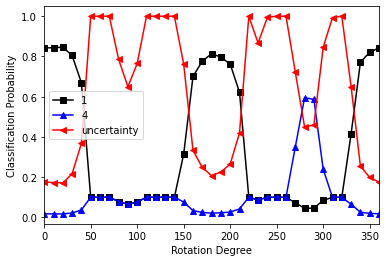

In [37]:
use_uncertainty = True
def rotating_image_classification(
    model, img, uncertainty=True, threshold=0.5, device=None):
    if not device:
        device = get_device()
    num_classes = 10
    Mdeg = 360
    Ndeg = int(Mdeg / 10) + 1
    ldeg = []
    lp = []
    lu = []
    classifications = []

    scores = np.zeros((1, num_classes))
    rimgs = np.zeros((28, 28 * Ndeg))
    for i, deg in enumerate(np.linspace(0, Mdeg, Ndeg)):
        nimg = rotate_img(img.numpy()[0], deg).reshape(28, 28)
        nimg = np.clip(a=nimg, a_min=0, a_max=1)
        rimgs[:, i * 28 : (i + 1) * 28] = nimg
        trans = transforms.ToTensor()
        img_tensor = trans(nimg)
        img_tensor.unsqueeze_(0)
        img_variable = torch.autograd.Variable(img_tensor)
        img_variable = img_variable.to(device)

        if uncertainty:
            output = model(img_variable)
            evidence = relu_evidence(output)
            alpha = evidence + 1
            uncertainty = num_classes / torch.sum(alpha, dim=1, keepdim=True)
            _, preds = torch.max(output, 1)
            prob = alpha / torch.sum(alpha, dim=1, keepdim=True)
            output = output.flatten()
            prob = prob.flatten()
            preds = preds.flatten()
            classifications.append(preds[0].item())
            lu.append(uncertainty.mean().tolist())
        else:
            output = model(img_variable)
            _, preds, = torch.max(output, 1)
            prob = F.softmax(output, dim=1)
            output = output.flatten()
            prob = prob.flatten()
            preds = preds.flatten()
            classifications.append(preds[0].item())

        scores += prob.detach().cpu().numpy() >= threshold
        ldeg.append(deg)
        lp.append(prob.tolist())

    labels = np.arange(10)[scores[0].astype(bool)]
    lp = np.array(lp)[:, labels]
    c = ["black", "blue", "red", "brown", "purple", "cyan"]
    marker = ["s", "^", "o"] * 2
    labels = labels.tolist()

    for i in range(len(labels)):
        plt.plot(ldeg, lp[:, i], marker=marker[i], c=c[i])

    if uncertainty:
        labels += ["uncertainty"]
        plt.plot(ldeg, lu, marker="<", c="red")

    plt.legend(labels)
 
    plt.xlim([0,Mdeg])  
    plt.xlabel('Rotation Degree')
    plt.ylabel('Classification Probability')
    plt.show()

    plt.figure(figsize=[6.2,100])
    plt.imshow(1-rimgs,cmap='gray')
    plt.axis('off')
    plt.show()

model.eval()

rotating_image_classification(
    model, digit_one, uncertainty=use_uncertainty,device=device)


In [80]:
def plot_metrics(states, reward, action_dist, n_ep,n_epoch):
    clear_output(wait=True)

    total_ep_reward = np.round(np.sum(reward))
    plt.figure(1)
    plt.clf()
    plt.title('Epoch {}: Reward Values for Episode {}, Total Reward= {}'.format(n_epoch,n_ep,total_ep_reward))
    plt.xlabel('Timestemp')
    plt.ylabel('Reward Value')
    plt.plot(reward)


    plt.figure(2)
    plt.clf()
    #rotations_t = torch.tensor(states, dtype=torch.float)
    plt.title('Training States for Episode '+str(n_ep))
    plt.xlabel('Timestep')
    plt.ylabel('Rotation Degree')
    plt.plot(states)
    plt.ylim([0, 360])

    plt.figure(3)
    plt.clf()
    #rotations_t = torch.tensor(states, dtype=torch.float)
    plt.title('abs(180 - Current Angle) for Episode '+str(n_ep))
    plt.xlabel('Timestep')
    plt.ylabel('Rotation Degree')
    rel_state = 180 - np.array(states)
    plt.plot(np.abs(rel_state))

    plt.figure(4)
    plt.clf()
    plt.title('Action Probability Distribution for Episode '+str(n_ep))
    names = ['Increase', 'Decrease', 'Maintain']
    plt.bar(names,action_dist)

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython and False:
        display.clear_output(wait=True)
        display.display(plt.gcf())



In [39]:
# Q-table is replaced by a neural network
class Agent(nn.Module):
    def __init__(self, observation_space_size: int, action_space_size: int, hidden_size: int):
        super(Agent, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(in_features=observation_space_size, out_features=hidden_size, bias=True),
            nn.PReLU(),
            nn.Linear(in_features=hidden_size, out_features=hidden_size, bias=True),
            nn.PReLU(),
            nn.Linear(in_features=hidden_size, out_features=action_space_size, bias=True)
        )

    def forward(self, x):
        x = normalize(x, dim=1)
        x = F.softmax(self.net(x),dim=1)
        return x

In [83]:
class Params:
    NUM_EPOCHS = 2000
    ALPHA = 5e-3        # learning rate, default = 5e-3
    BATCH_SIZE = 30    # how many episodes we want to pack into an epoch, default = 64
    GAMMA = 0.99     # discount rate
    HIDDEN_SIZE = 64    # number of hidden nodes we have in our dnn
    BETA = 0.0001          # the entropy bonus multiplier
    EPISODE_LEN = 720


In [84]:
class mnist_rotate_env():
    def __init__(self,input_digit):
        self.state = None
        self.digit = input_digit
        self.timestep = 0

    def step(self,action):
        assert self.state is not None, "Call reset before using step method."
        assert action in [0,1,2]
        assert self.digit is not None

        #Apply action to find new state
        new_state = self.state
    
        if(action==0): 
            new_state[1] = new_state[1] + 5
            if(new_state[1]>359):
                new_state[1] = new_state[1]-360 
        elif(action==1):
            new_state[1] = new_state[1] - 5
            if(new_state[1]<0):
                new_state[1] = 360+new_state[1]

        new_rotated_one = rotate_img(self.digit.reshape(28,28),new_state[1])
        new_rotated_one = torch.tensor(new_rotated_one[None, :])
        prob, preds,uncertainty = model_predict(model,new_rotated_one)

        #Calculate reward
        reward = (1-uncertainty.item()) 

        self.state = new_state #Set new state
        self.timestep = self.timestep + 1 #Increment time

        done = (self.timestep==Params.EPISODE_LEN)

        return new_state, reward, done #preds.item()
    
    def reset(self):
        self.timestep = 0
        spawn_rotation = random.randint(0,360)
        current_rotation = spawn_rotation
        self.state = [spawn_rotation,current_rotation]

        return self.state

In [85]:
class PolicyGradient:
    def __init__(self, input = digit_one, use_cuda: bool = True):

        self.input = input
        self.NUM_EPOCHS = Params.NUM_EPOCHS
        self.ALPHA = Params.ALPHA
        self.BATCH_SIZE = Params.BATCH_SIZE
        self.GAMMA = Params.GAMMA
        self.HIDDEN_SIZE = Params.HIDDEN_SIZE
        self.BETA = Params.BETA
        self.DEVICE = torch.device('cuda' if torch.cuda.is_available() and use_cuda else 'cpu')

        # instantiate the tensorboard writer
        self.writer = SummaryWriter(comment=f'_PG_CP_Gamma={self.GAMMA},'
                                            f'LR={self.ALPHA},'
                                            f'BS={self.BATCH_SIZE},'
                                            f'NH={self.HIDDEN_SIZE},'
                                            f'BETA={self.BETA}')

        # create the environment
        #Environemnt Parameters
        self.obs_state_size = 2
        self.action_state_size = 3

        self.env = mnist_rotate_env(input)

        # the agent driven by a neural network architecture
        self.agent = Agent(observation_space_size=self.obs_state_size,
                           action_space_size=self.action_state_size,
                           hidden_size=self.HIDDEN_SIZE).to(self.DEVICE)

        self.adam = optim.Adam(params=self.agent.parameters(), lr=self.ALPHA)

        self.total_rewards = deque([], maxlen=100)

        # flag to figure out if we have render a single episode current epoch
        self.finished_rendering_this_epoch = False

    def solve_environment(self):
        """
            The main interface for the Policy Gradient solver
        """
        # init the episode and the epoch
        episode = 0
        epoch = 0

        # init the epoch arrays
        # used for entropy calculation
        epoch_logits = torch.empty(size=(0, self.action_state_size), device=self.DEVICE)
        epoch_weighted_log_probs = torch.empty(size=(0,), dtype=torch.float, device=self.DEVICE)

        while True:

            # play an episode of the environment
            (episode_weighted_log_prob_trajectory,
             episode_logits,
             sum_of_episode_rewards,
             episode) = self.play_episode(episode=episode,epoch=epoch)

            # after each episode append the sum of total rewards to the deque
            self.total_rewards.append(sum_of_episode_rewards)

            # append the weighted log-probabilities of actions
            epoch_weighted_log_probs = torch.cat((epoch_weighted_log_probs, episode_weighted_log_prob_trajectory),
                                                 dim=0)

            # append the logits - needed for the entropy bonus calculation
            epoch_logits = torch.cat((epoch_logits, episode_logits), dim=0)

            # if the epoch is over - we have epoch trajectories to perform the policy gradient
            if episode >= self.BATCH_SIZE:

                # reset the rendering flag
                self.finished_rendering_this_epoch = False

                # reset the episode count
                episode = 0

                # increment the epoch
                epoch += 1

                # calculate the loss
                loss, entropy = self.calculate_loss(epoch_logits=epoch_logits,
                                                    weighted_log_probs=epoch_weighted_log_probs)

                # zero the gradient
                self.adam.zero_grad()

                # backprop
                loss.backward()

                # update the parameters
                self.adam.step()

                # feedback
                print("\r", f"Epoch: {epoch}, Avg Return per Epoch: {np.mean(self.total_rewards):.3f}",
                      end="",
                      flush=True)

                self.writer.add_scalar(tag='Average Return over 100 episodes',
                                       scalar_value=np.mean(self.total_rewards),
                                       global_step=epoch)

                self.writer.add_scalar(tag='Entropy',
                                       scalar_value=entropy,
                                       global_step=epoch)

                # reset the epoch arrays
                # used for entropy calculation
                epoch_logits = torch.empty(size=(0, self.action_state_size), device=self.DEVICE)
                epoch_weighted_log_probs = torch.empty(size=(0,), dtype=torch.float, device=self.DEVICE)

                ##EXIT conditions
                # check if solved
                if np.mean(self.total_rewards) > 560: #550
                    print('\nSolved!')
                    torch.save(self.agent.state_dict(), 'ultra_EDL_RL_agent_model.pyt')
                    break

                if(epoch==self.NUM_EPOCHS):
                    print('\nReached epoch limit!')
                    torch.save(self.agent.state_dict(), 'ultra_Lim_EDL_RL_agent_model.pyt')
                    break

        # close the environment
        #self.env.close()

        # close the writer
        self.writer.close()

    def play_episode(self, episode: int, epoch: int):

        #sum_weighted_log_probs: the sum of the log-prob of an action multiplied by the reward-to-go from that state
        #episode_logits: the logits of every step of the episode - needed to compute entropy for entropy bonus
    
        # reset the environment to a random initial state every epoch
        state = self.env.reset()

        # initialize the episode arrays
        episode_actions = torch.empty(size=(0,), dtype=torch.long, device=self.DEVICE)
        episode_logits = torch.empty(size=(0, self.action_state_size), device=self.DEVICE)
        average_rewards = np.empty(shape=(0,), dtype=float)
        episode_rewards = np.empty(shape=(0,), dtype=float)

        #initalise metrics arrays
        eps_states = []
        eps_rewards = []
        eps_action_dist = np.array([0,0,0])


        # episode loop
        while True:
            # get the action logits from the agent - (preferences)
            action_logits = self.agent(torch.tensor(state).float().unsqueeze(dim=0).to(self.DEVICE))

            # append the logits to the episode logits list
            episode_logits = torch.cat((episode_logits, action_logits), dim=0)

            # sample an action according to the action distribution
            action = Categorical(logits=action_logits).sample()


            # append the action to the episode action list to obtain the trajectory
            # we need to store the actions and logits so we could calculate the gradient of the performance
            episode_actions = torch.cat((episode_actions, action), dim=0)

            # take the chosen action, observe the reward and the next state
            state, reward, done  = self.env.step(action=action.cpu().item())

            #Update episode metrics
            eps_states.append(state[1])
            eps_rewards.append(reward)
            eps_action_dist = eps_action_dist + action_logits.cpu().detach()[0].numpy()


            # append the reward to the rewards pool that we collect during the episode
            # we need the rewards so we can calculate the weights for the policy gradient
            # and the baseline of average
            episode_rewards = np.concatenate((episode_rewards, np.array([reward])), axis=0)

            # here the average reward is state specific
            average_rewards = np.concatenate((average_rewards,
                                              np.expand_dims(np.mean(episode_rewards), axis=0)),
                                             axis=0)

            # the episode is over
            if done:
                # increment the episode
                episode += 1

                # turn the rewards we accumulated during the episode into the rewards-to-go:
                # earlier actions are responsible for more rewards than the later taken actions
                discounted_rewards_to_go = PolicyGradient.get_discounted_rewards(rewards=episode_rewards,
                                                                                 gamma=self.GAMMA)
                discounted_rewards_to_go -= average_rewards  # baseline - state specific average

                # # calculate the sum of the rewards for the running average metric
                sum_of_rewards = np.sum(episode_rewards)

                # set the mask for the actions taken in the episode
                mask = one_hot(episode_actions, num_classes=self.action_state_size)

                # calculate the log-probabilities of the taken actions
                # mask is needed to filter out log-probabilities of not related logits
                episode_log_probs = torch.sum(mask.float() * log_softmax(episode_logits, dim=1), dim=1)

                # weight the episode log-probabilities by the rewards-to-go
                episode_weighted_log_probs = episode_log_probs * \
                    torch.tensor(discounted_rewards_to_go).float().to(self.DEVICE)

                # calculate the sum over trajectory of the weighted log-probabilities
                sum_weighted_log_probs = torch.sum(episode_weighted_log_probs).unsqueeze(dim=0)

                # won't render again this epoch
                self.finished_rendering_this_epoch = True

                #Plot episode metrics
                mean_action_dist = eps_action_dist/Params.EPISODE_LEN
                plot_metrics(eps_states,eps_rewards, mean_action_dist, episode,epoch)

                return sum_weighted_log_probs, episode_logits, sum_of_rewards, episode

    def calculate_loss(self, epoch_logits: torch.Tensor, weighted_log_probs: torch.Tensor):
        # epoch_logits: logits of the policy network we have collected over the epoch
        # weighted_log_probs: loP * W of the actions taken
        policy_loss = -1 * torch.mean(weighted_log_probs)

        # add the entropy bonus
        p = softmax(epoch_logits, dim=1)
        log_p = log_softmax(epoch_logits, dim=1)
        entropy = -1 * torch.mean(torch.sum(p * log_p, dim=1), dim=0)
        entropy_bonus = -1 * self.BETA * entropy

        return policy_loss + entropy_bonus, entropy

    @staticmethod
    def get_discounted_rewards(rewards: np.array, gamma: float) -> np.array:
        discounted_rewards = np.empty_like(rewards, dtype=float)
        for i in range(rewards.shape[0]):
            gammas = np.full(shape=(rewards[i:].shape[0]), fill_value=gamma)
            discounted_gammas = np.power(gammas, np.arange(rewards[i:].shape[0]))
            discounted_reward = np.sum(rewards[i:] * discounted_gammas)
            discounted_rewards[i] = discounted_reward
        return discounted_rewards

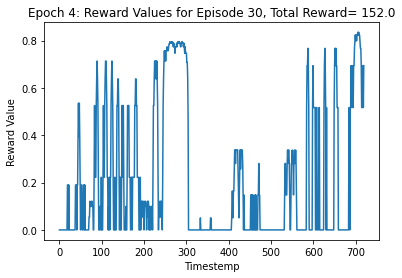

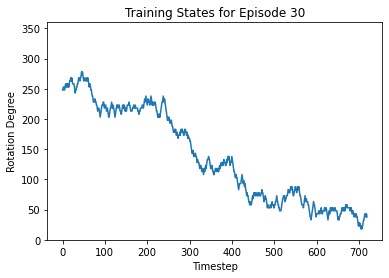

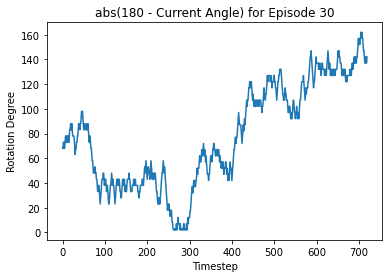

KeyboardInterrupt: 

In [86]:
#Reinforcement Learning Trial
policy_gradient = PolicyGradient() 
policy_gradient.solve_environment()